# Hyperparameter tuning -- dropout rate exploration

## Computational challenges:
- Qstar data cannot be fully saved <-- only have 1 year saved so far
  - Kernel dies before this can happen!!
  - Saving process is paralleized (via #workers/#threads demo from Julius)
- Data only from south Atlantic right now
  - Training/testing datasets became huge is multiple regions are invovled
  - PLAN: Determine hyperparameters for south Atlantic, then generalize
- Hyperparameter testing must occur
  - Lots of NN training to do -> very expensive

## Training data:
- Monthly data (every 30th day)
- First 9 months 
- Qstar data
- South Atlantic region

### Input variables:
- u_rel = relative u_dir velocity b/n ocean and atmos 
- v_rel = relative v_dir velocity b/n ocean and atmos 
- q_ref = specific humidity at 2m in atmos 
- t_ref = temperature at 2m in atmos 
- sst = sea surface temp

### Output variable:
- Qstar = SGS heat flux contribution

## Testing data:
- Same structure as input data

## Hyperparameter testing plan:
- Keep batch size and training/testing data same
- Experiment with SGD vs Adam optimizers
- Vary dropout and learning rate

# Training/Testing Dataset Loading 

In [1]:
from xgcm import Grid
import pop_tools
import gcsfs
import fsspec as fs
import numpy as np
import xesmf as xe
import xarray as xr
import random
import matplotlib.pyplot as plt
import warnings
from xgcm import Grid
import importlib
import preprocessing
import os
import xrft
import gcm_filters
import random

warnings.filterwarnings("ignore")

importlib.reload(preprocessing)
from preprocessing import preprocess_data

from gcm_filtering import filter_inputs_dataset
from gcm_filtering import filter_inputs

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset

ds_merged = preprocess_data()
ds_merged

Load Data
Interpolating ocean velocities
Modify units
Load Data
Align in time
Interpolating ocean velocities
Regrid Atmospheric Data
Modify units
Mask nans
Calculate relative wind


<xarray.Dataset> Size: 3TB
Dimensions:       (time: 7305, yt_ocean: 2700, xt_ocean: 3600)
Coordinates:
  * time          (time) object 58kB 0181-01-01 12:00:00 ... 0200-12-31 12:00:00
  * xt_ocean      (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.85 79.95
  * yt_ocean      (yt_ocean) float64 22kB -81.11 -81.07 -81.02 ... 89.94 89.98
    area_t        (yt_ocean, xt_ocean) float64 78MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dxt           (yt_ocean, xt_ocean) float64 78MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dyt           (yt_ocean, xt_ocean) float64 78MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolat_t      (yt_ocean, xt_ocean) float32 39MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolon_t      (yt_ocean, xt_ocean) float32 39MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    ht            (yt_ocean, xt_ocean) float32 39MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    kmt           (yt_ocean, xt_ocean) float32 39MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    wet           (yt_ocean, xt_ocean) float64 78MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
Data variables:
    slp           (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_ref         (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_ref         (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    t_ref         (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    q_ref         (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    wind          (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    surface_temp  (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_ocean       (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_ocean       (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_relative    (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_relative    (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

In [2]:
ds_training = xr.open_dataset(
    "gs://leap-persistent/panalluri/ds_trainingData_southAtlantic.zarr", engine="zarr", chunks={}
) 
ds_training

<xarray.Dataset> Size: 11MB
Dimensions:   (time: 9, yt_ocean: 163, xt_ocean: 150)
Coordinates:
  * time      (time) object 72B 0181-01-01 12:00:00 ... 0181-08-29 12:00:00
  * xt_ocean  (xt_ocean) float64 1kB -24.95 -24.85 -24.75 ... -10.15 -10.05
  * yt_ocean  (yt_ocean) float64 1kB -29.98 -29.89 -29.81 ... -15.17 -15.07
Data variables:
    Q_out     (time, yt_ocean, xt_ocean) float64 2MB dask.array<chunksize=(5, 82, 75), meta=np.ndarray>
    Q_star    (time, yt_ocean, xt_ocean) float32 880kB dask.array<chunksize=(5, 82, 150), meta=np.ndarray>
    q_ref     (time, yt_ocean, xt_ocean) float64 2MB dask.array<chunksize=(5, 82, 75), meta=np.ndarray>
    sst       (time, yt_ocean, xt_ocean) float64 2MB dask.array<chunksize=(5, 82, 75), meta=np.ndarray>
    t_ref     (time, yt_ocean, xt_ocean) float64 2MB dask.array<chunksize=(5, 82, 75), meta=np.ndarray>
    u_rel     (time, yt_ocean, xt_ocean) float64 2MB dask.array<chunksize=(5, 82, 75), meta=np.ndarray>
    v_rel     (time, yt_ocean, xt_ocean) float64 2MB dask.array<chunksize=(5, 82, 75), meta=np.ndarray>

In [3]:
ds_testing = xr.open_dataset(
    "gs://leap-persistent/panalluri/ds_testingData_southAtlantic.zarr", engine="zarr", chunks={}
) 
ds_testing

<xarray.Dataset> Size: 5MB
Dimensions:   (time: 4, yt_ocean: 163, xt_ocean: 150)
Coordinates:
  * time      (time) object 32B 0181-09-28 12:00:00 ... 0181-12-27 12:00:00
  * xt_ocean  (xt_ocean) float64 1kB -24.95 -24.85 -24.75 ... -10.15 -10.05
  * yt_ocean  (yt_ocean) float64 1kB -29.98 -29.89 -29.81 ... -15.17 -15.07
Data variables:
    Q_out     (time, yt_ocean, xt_ocean) float64 782kB dask.array<chunksize=(2, 82, 150), meta=np.ndarray>
    Q_star    (time, yt_ocean, xt_ocean) float32 391kB dask.array<chunksize=(2, 163, 150), meta=np.ndarray>
    q_ref     (time, yt_ocean, xt_ocean) float64 782kB dask.array<chunksize=(2, 82, 150), meta=np.ndarray>
    sst       (time, yt_ocean, xt_ocean) float64 782kB dask.array<chunksize=(2, 82, 150), meta=np.ndarray>
    t_ref     (time, yt_ocean, xt_ocean) float64 782kB dask.array<chunksize=(2, 82, 150), meta=np.ndarray>
    u_rel     (time, yt_ocean, xt_ocean) float64 782kB dask.array<chunksize=(2, 82, 150), meta=np.ndarray>
    v_rel     (time, yt_ocean, xt_ocean) float64 782kB dask.array<chunksize=(2, 82, 150), meta=np.ndarray>

#### Convert to torch tensor

In [4]:
# Create a 4D tensor using all variables from ds_testing
# First, extract the values from the dataset
u_rel = ds_training['u_rel'].values
v_rel = ds_training['v_rel'].values
t_ref = ds_training['t_ref'].values
q_ref = ds_training['q_ref'].values
sst = ds_training['sst'].values
Q_out = ds_training['Q_out'].values #Q_LR
Q_star = ds_training['Q_star'].values

# Stack these arrays into a 4D tensor
# Shape will be (time, yt_ocean, xt_ocean, num_variables)
training_NN_inputs = torch.tensor(np.stack([u_rel, v_rel, t_ref, q_ref, sst, Q_out, Q_star], axis=3))

# Now data_array is a 4D tensor
training_NN_inputs


tensor([[[[-9.6512e-01, -6.3304e+00,  2.9336e+02,  ...,  2.9329e+02,
           -1.0321e+00,  2.0054e+00],
          [-1.0361e+00, -6.3221e+00,  2.9337e+02,  ...,  2.9329e+02,
           -9.1159e-01,  2.1065e+00],
          [-1.1081e+00, -6.3105e+00,  2.9337e+02,  ...,  2.9330e+02,
           -7.9348e-01,  2.2065e+00],
          ...,
          [-6.0987e+00,  1.2395e+00,  2.9200e+02,  ...,  2.9379e+02,
           -1.4039e+00, -1.1035e+01],
          [-6.1073e+00,  1.2843e+00,  2.9200e+02,  ...,  2.9378e+02,
           -1.2787e+00, -1.0932e+01],
          [-6.1152e+00,  1.3286e+00,  2.9199e+02,  ...,  2.9378e+02,
           -1.1546e+00, -1.0812e+01]],

         [[-9.2848e-01, -6.3078e+00,  2.9341e+02,  ...,  2.9335e+02,
           -9.5882e-01,  2.0596e+00],
          [-9.9952e-01, -6.2975e+00,  2.9341e+02,  ...,  2.9335e+02,
           -8.3501e-01,  2.1590e+00],
          [-1.0716e+00, -6.2841e+00,  2.9341e+02,  ...,  2.9335e+02,
           -7.1359e-01,  2.2578e+00],
          ...,
     

In [5]:
# Create a 4D tensor using all variables from ds_testing
# First, extract the values from the dataset
u_rel = ds_testing['u_rel'].values
v_rel = ds_testing['v_rel'].values
t_ref = ds_testing['t_ref'].values
q_ref = ds_testing['q_ref'].values
sst = ds_testing['sst'].values
Q_out = ds_testing['Q_out'].values
Q_star = ds_testing['Q_star'].values

# Stack these arrays into a 4D tensor
# Shape will be (time, yt_ocean, xt_ocean, num_variables)
testing_NN_inputs = torch.tensor(np.stack([u_rel, v_rel, t_ref, q_ref, sst, Q_out, Q_star], axis=3))

# Now data_array is a 4D tensor
testing_NN_inputs


tensor([[[[ 9.5125e-02, -2.7079e+00,  2.8859e+02,  ...,  2.8990e+02,
           -2.9795e+00, -2.2367e+00],
          [ 7.7923e-02, -2.7298e+00,  2.8857e+02,  ...,  2.8989e+02,
           -3.0489e+00, -2.3679e+00],
          [ 6.0952e-02, -2.7519e+00,  2.8855e+02,  ...,  2.8988e+02,
           -3.1185e+00, -2.5164e+00],
          ...,
          [-2.8880e+00,  9.1772e-02,  2.8700e+02,  ...,  2.8887e+02,
           -2.7768e+00, -2.1455e+00],
          [-2.9163e+00,  1.3600e-01,  2.8699e+02,  ...,  2.8886e+02,
           -2.8430e+00, -1.9782e+00],
          [-2.9451e+00,  1.7983e-01,  2.8698e+02,  ...,  2.8885e+02,
           -2.9108e+00, -1.8071e+00]],

         [[-1.9902e-02, -2.6774e+00,  2.8861e+02,  ...,  2.8994e+02,
           -3.0368e+00, -2.3337e+00],
          [-3.6797e-02, -2.6983e+00,  2.8859e+02,  ...,  2.8994e+02,
           -3.1062e+00, -2.4636e+00],
          [-5.3434e-02, -2.7196e+00,  2.8857e+02,  ...,  2.8993e+02,
           -3.1757e+00, -2.6105e+00],
          ...,
     

## NN architecture and testing/training functions setup

In [6]:
image_height = training_NN_inputs.shape[1]
image_width = training_NN_inputs.shape[2]
output_channels = 1 #output can be in grayscale

In [7]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3, padding=1)  # Adjust input channels to 6
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * (image_height // 8) * (image_width // 8), 128)  # Adjust for image dimensions = bring to correct dimension for pooling input size
        self.fc2 = nn.Linear(128, output_channels * image_height * image_width)  # Adjust output shape
        self.dropout = nn.Dropout(dropout_rate) # Dropout Layer

    def forward(self, x):
        x = nn.ReLU()(self.conv1(x))
        x = nn.MaxPool2d(kernel_size=2)(x)
        x = nn.ReLU()(self.conv2(x))
        x = nn.MaxPool2d(kernel_size=2)(x)
        x = nn.ReLU()(self.conv3(x))
        x = nn.MaxPool2d(kernel_size=2)(x)
        
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = nn.ReLU()(self.fc1(x))
        x = self.dropout(x) 
        x = self.fc2(x)
        x = x.view(-1, output_channels, image_height, image_width)  # Reshape to output image
        return x

dropout_rate = 0.3
model = SimpleCNN()
print(model)

SimpleCNN(
  (conv1): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=23040, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=24450, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


In [8]:
class TensorDataset(Dataset):
    def __init__(self, tensor_data):
        self.tensor_data = tensor_data  # The 4D tensor dataset
        self.time_steps = tensor_data.shape[0]  # Total number of time steps

    def __len__(self):
        return self.time_steps  # Total number of samples (time steps)

    def __getitem__(self, idx):
        # Access the data at the specified index (time step)
        data = self.tensor_data[idx]  # Get data for the specified time step
        
        # Assuming the shape is (x, y, vars), we need to split the last dimension
        # Let's say vars=6, then we extract the input images
        input_images = data[:, :, :6]  # Take the first 6 variables (assuming they are the images)

        # Load the corresponding target, assuming it's the next variable (var 7)
        target = data[:, :, 6]  # Replace with your actual target variable index

        return input_images, target  # Return input (6 images) and target


In [9]:
def train_model(model, train_loader, criterion, optimizer, num_epochs=20):
    # Loop over epochs
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0

        # Iterate through the training dataset
        for inputs, targets in train_loader:
            # inputs shape: [1, y, x, variables (6)]
            # targets shape: [1, y, x]

            # Squeeze batch dimension (since batch_size=1)
            inputs = inputs.squeeze(0).permute(2, 0, 1)  # Reshape to (vars, y, x) --> CNN input expects vars/channels first 
            targets = targets.squeeze(0)  # Shape: (y, x)

            # Convert inputs to float32
            inputs = inputs.float()
            targets = targets.float()

            # Zero/reset the parameter gradients before next iteration
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs.unsqueeze(0))  # Add batch dimension back for CNN (shape: [1, vars, y, x])
            targets = targets.unsqueeze(0)  # Add batch dimension to targets

            # Compute loss
            loss = criterion(outputs, targets)

            # Backward pass and optimization step
            loss.backward()
            optimizer.step()

            # Accumulate running loss
            running_loss += loss.item()

        # Print epoch statistics
        train_loss = running_loss / len(train_loader)  # Average loss over the batch
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}")

    # print("Training complete!")
    return train_loss    

In [10]:
def evaluate_model(model, test_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    all_predictions = []
    all_targets = []

    with torch.no_grad():  # Disable gradient calculation for evaluation
        for inputs, targets in test_loader:

            # Question: Should I take out the targets' squeeze and unsqueeze here?
            inputs = inputs.squeeze(0).permute(2, 0, 1).float()  # Prepare input shape
            targets = targets.squeeze(0).float()  # Prepare target shape

            # Forward pass
            outputs = model(inputs.unsqueeze(0))  # Add batch dimension
            targets = targets.unsqueeze(0)

            # Calculate loss
            loss = criterion(outputs, targets)

            # Accumulate loss
            total_loss += loss.item()

            # Store predictions and targets
            all_predictions.append(outputs.cpu())  # Store outputs directly
            all_targets.append(targets.cpu())  # Store targets directly

    average_loss = total_loss / len(test_loader)

    # Convert lists to tensors
    all_predictions = torch.cat(all_predictions, dim=0)  # Concatenate along the batch dimension
    all_targets = torch.cat(all_targets, dim=0)  # Concatenate along the batch dimension

    return average_loss, all_predictions, all_targets


## Hyperparameter tuning cases:

All cases have:
- Same NN architecture (#layers, #neurons in layers, etc)
- Same batch size and training/testing data
- Same activation function: ReLU
- Same loss function: MSE Loss
- 

#### Epochs = 20
| Optimizer = Adam       | Learning Rate = 0.1 | Dropout Rate = 0.3 | 
|------------------|---------------|--------------|
| **Learning Rate = 0.01**            |   ------   | Case 1: LR=0.01, DR=0.3   | 
| **Drouput Rate = 0.5**            | Case 2: LR=0.1, DR=0.5     |  ------   | 

| Optimizer = SGD       | Learning Rate = 0.1 | Dropout Rate = 0.3 | 
|------------------|---------------|--------------|
| **Learning Rate = 0.01**            |   ------   | Case 3: LR=0.01, DR=0.3   | 
| **Drouput Rate = 0.5**            | Case 4: LR=0.1, DR=0.5     |   ------  | 


#### Epochs = 50
| Optimizer = Adam       | Learning Rate = 0.1 | Dropout Rate = 0.3 | 
|------------------|---------------|--------------|
| **Learning Rate = 0.01**            |   ------   | Case 5: LR=0.01, DR=0.3   | 
| **Drouput Rate = 0.5**            | Case 6: LR=0.1, DR=0.5     |  ------   | 

| Optimizer = SGD       | Learning Rate = 0.1 | Dropout Rate = 0.3 | 
|------------------|---------------|--------------|
| **Learning Rate = 0.01**            |   ------   | Case 7: LR=0.01, DR=0.3   | 
| **Drouput Rate = 0.5**            | Case 8: LR=0.1, DR=0.5     |   ------  | 


#### Epochs = 100
| Optimizer = Adam       | Learning Rate = 0.1 | Dropout Rate = 0.3 | 
|------------------|---------------|--------------|
| **Learning Rate = 0.01**            |   ------   | Case 9: LR=0.01, DR=0.3   | 
| **Drouput Rate = 0.5**            | Case 10: LR=0.1, DR=0.5     |  ------   | 

| Optimizer = SGD       | Learning Rate = 0.1 | Dropout Rate = 0.3 | 
|------------------|---------------|--------------|
| **Learning Rate = 0.01**            |   ------   | Case 11: LR=0.01, DR=0.3   | 
| **Drouput Rate = 0.5**            | Case 12: LR=0.1, DR=0.5     |   ------  | 


### Hyperparameter tuning code

In [11]:
import itertools
import torch.optim as optim

# Define possible hyperparameter values
learning_rates = [0.001, 0.01, 0.1]
dropout_rates = [0.3, 0.5, 0.7]
optimizers = [optim.SGD, optim.Adam]
epochs_options = [20, 50, 100]  # Epoch values to test

# Generate all combinations of hyperparameters and epochs
param_grid = list(itertools.product(learning_rates, dropout_rates, optimizers, epochs_options))

# Create datasets and DataLoader 
train_dataset = TensorDataset(training_NN_inputs)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=4)
test_dataset = TensorDataset(testing_NN_inputs)  
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Track the best results
best_model = None
best_val_loss = float('inf')
best_params = {}

# Hyperparameter tuning loop
for lr, dropout_rate, optimizer_class, epochs in param_grid:
    print(f"Training with lr={lr}, dropout_rate={dropout_rate}, optimizer={optimizer_class.__name__}, epochs={epochs}")
    
    # Initialize model, loss function, and optimizer
    dropout_rate = dropout_rate
    model = SimpleCNN()
    criterion = nn.MSELoss()  # Replace with your actual loss function
    optimizer = optimizer_class(model.parameters(), lr=lr)
    
    # Training loop for the specified number of epochs (already handled in train_model)
    train_loss = train_model(model, train_loader, criterion, optimizer, num_epochs=epochs)  # Pass epochs here
    val_loss, _, _ = evaluate_model(model, test_loader, criterion)  # Get val_loss from evaluate_model
    
    # Print progress after training
    print(f"Final Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")
    
    # Keep track of the best model based on validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model
        best_params = {'learning_rate': lr, 'dropout_rate': dropout_rate, 'optimizer': optimizer_class.__name__, 'epochs': epochs}

print(f"Best model hyperparameters: {best_params}")

Training with lr=0.001, dropout_rate=0.3, optimizer=SGD, epochs=20
Final Training Loss: 38.6296, Validation Loss: 14.4914
Training with lr=0.001, dropout_rate=0.3, optimizer=SGD, epochs=50
Final Training Loss: 38.6267, Validation Loss: 14.4880
Training with lr=0.001, dropout_rate=0.3, optimizer=SGD, epochs=100
Final Training Loss: 38.6050, Validation Loss: 14.4870
Training with lr=0.001, dropout_rate=0.3, optimizer=Adam, epochs=20
Final Training Loss: 38.0708, Validation Loss: 14.2930
Training with lr=0.001, dropout_rate=0.3, optimizer=Adam, epochs=50
Final Training Loss: 18.4397, Validation Loss: 17.4450
Training with lr=0.001, dropout_rate=0.3, optimizer=Adam, epochs=100
Final Training Loss: 13.0473, Validation Loss: 13.5507
Training with lr=0.001, dropout_rate=0.5, optimizer=SGD, epochs=20
Final Training Loss: 38.6278, Validation Loss: 14.4904
Training with lr=0.001, dropout_rate=0.5, optimizer=SGD, epochs=50
Final Training Loss: 38.6030, Validation Loss: 14.4889
Training with lr=0.

## Testing the "best hyperparameter combo": 
- learning_rate = 0.01
- dropout_rate = 0.7
- optimizer = Adam
- epochs = 20

In [15]:
lr = 0.01
dropout_rate = 0.7
optimizer = optim.Adam(model.parameters(), lr=lr)
epochs = 20

# Create datasets and DataLoader 
train_dataset = TensorDataset(training_NN_inputs)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=4)
test_dataset = TensorDataset(testing_NN_inputs)  
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

print(f"Training with lr={lr}, dropout_rate={dropout_rate}, optimizer=Adam, epochs={epochs}")
    
# Initialize model, loss function, and optimizer
dropout_rate = dropout_rate
model = SimpleCNN()
criterion = nn.MSELoss()  # Replace with your actual loss function
    
# Training loop for the specified number of epochs (already handled in train_model)
train_loss = train_model(model, train_loader, criterion, optimizer, num_epochs=epochs)  # Pass epochs here
val_loss, _, _ = evaluate_model(model, test_loader, criterion)  # Get val_loss from evaluate_model
    
# Print progress after training
print(f"Final Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

Training with lr=0.01, dropout_rate=0.7, optimizer=Adam, epochs=20
Epoch [1/20], Loss: 67.0301
Epoch [2/20], Loss: 70.3333
Epoch [3/20], Loss: 73.2540
Epoch [4/20], Loss: 64.2571
Epoch [5/20], Loss: 71.7271
Epoch [6/20], Loss: 72.6710
Epoch [7/20], Loss: 67.6050
Epoch [8/20], Loss: 66.6404
Epoch [9/20], Loss: 69.5544
Epoch [10/20], Loss: 66.7555
Epoch [11/20], Loss: 65.5473
Epoch [12/20], Loss: 71.2911
Epoch [13/20], Loss: 69.4802
Epoch [14/20], Loss: 71.8747
Epoch [15/20], Loss: 73.3006
Epoch [16/20], Loss: 72.7084
Epoch [17/20], Loss: 68.8134
Epoch [18/20], Loss: 70.0522
Epoch [19/20], Loss: 70.8001
Epoch [20/20], Loss: 68.0393
Final Training Loss: 68.0393, Validation Loss: 23.9798


### Why is the validation loss high here?
We decided what the optimal hyperparameter combo based on minimizing validation loss. However, we ran the training loops for each of the hyperparameter combos one after another. This seems to improve validation loss results. Why is that? Ask Dhruv about it. The internet seems to not give me a straight answer. 

#### Trying "optimal hyperparameter combo" with epochs = 100

In [16]:
lr = 0.01
dropout_rate = 0.7
optimizer = optim.Adam(model.parameters(), lr=lr)
epochs = 100

# Create datasets and DataLoader 
train_dataset = TensorDataset(training_NN_inputs)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=4)
test_dataset = TensorDataset(testing_NN_inputs)  
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

print(f"Training with lr={lr}, dropout_rate={dropout_rate}, optimizer=Adam, epochs={epochs}")
    
# Initialize model, loss function, and optimizer
dropout_rate = dropout_rate
model = SimpleCNN()
criterion = nn.MSELoss()  # Replace with your actual loss function
    
# Training loop for the specified number of epochs (already handled in train_model)
train_loss = train_model(model, train_loader, criterion, optimizer, num_epochs=epochs)  # Pass epochs here
val_loss, _, _ = evaluate_model(model, test_loader, criterion)  # Get val_loss from evaluate_model
    
# Print progress after training
print(f"Final Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

Training with lr=0.01, dropout_rate=0.7, optimizer=Adam, epochs=100
Epoch [1/100], Loss: 49.0574
Epoch [2/100], Loss: 48.3510
Epoch [3/100], Loss: 47.2044
Epoch [4/100], Loss: 48.7232
Epoch [5/100], Loss: 51.3792
Epoch [6/100], Loss: 50.4348
Epoch [7/100], Loss: 50.1453
Epoch [8/100], Loss: 48.7764
Epoch [9/100], Loss: 49.5437
Epoch [10/100], Loss: 50.2796
Epoch [11/100], Loss: 48.1424
Epoch [12/100], Loss: 47.6960
Epoch [13/100], Loss: 51.0665
Epoch [14/100], Loss: 50.4861
Epoch [15/100], Loss: 46.8479
Epoch [16/100], Loss: 47.9014
Epoch [17/100], Loss: 49.6858
Epoch [18/100], Loss: 49.2795
Epoch [19/100], Loss: 49.4082
Epoch [20/100], Loss: 48.6490
Epoch [21/100], Loss: 49.8976
Epoch [22/100], Loss: 49.5393
Epoch [23/100], Loss: 49.8309
Epoch [24/100], Loss: 48.0878
Epoch [25/100], Loss: 49.8881
Epoch [26/100], Loss: 48.1961
Epoch [27/100], Loss: 49.1294
Epoch [28/100], Loss: 49.6670
Epoch [29/100], Loss: 47.4118
Epoch [30/100], Loss: 49.9710
Epoch [31/100], Loss: 50.8206
Epoch [32/1

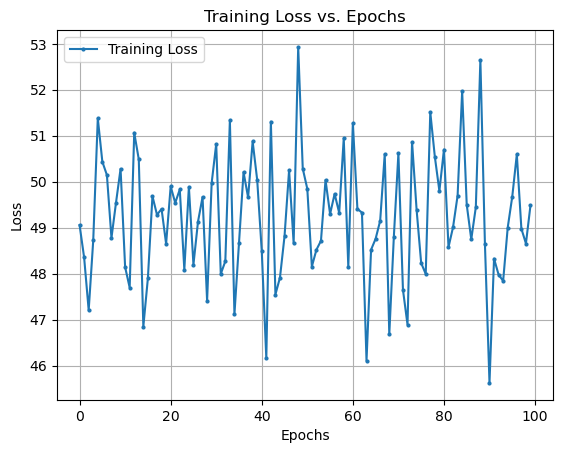

In [17]:
training_losses = [
    49.0574, 48.3510, 47.2044, 48.7232, 51.3792, 50.4348, 50.1453, 48.7764, 49.5437, 50.2796,
    48.1424, 47.6960, 51.0665, 50.4861, 46.8479, 47.9014, 49.6858, 49.2795, 49.4082, 48.6490,
    49.8976, 49.5393, 49.8309, 48.0878, 49.8881, 48.1961, 49.1294, 49.6670, 47.4118, 49.9710,
    50.8206, 47.9925, 48.2693, 51.3366, 47.1128, 48.6629, 50.2084, 49.6581, 50.8762, 50.0362,
    48.4913, 46.1607, 51.3057, 47.5459, 47.9144, 48.8151, 50.2489, 48.6639, 52.9319, 50.2858,
    49.8446, 48.1534, 48.5195, 48.7145, 50.0370, 49.2972, 49.7352, 49.3215, 50.9433, 48.1498,
    51.2731, 49.4070, 49.3277, 46.1042, 48.5199, 48.7592, 49.1503, 50.6031, 46.6778, 48.8012,
    50.6155, 47.6493, 46.8913, 50.8637, 49.3846, 48.2306, 47.9925, 51.5122, 50.5432, 49.7978,
    50.6989, 48.5763, 49.0116, 49.6975, 51.9665, 49.5009, 48.7453, 49.4473, 52.6502, 48.6388,
    45.6225, 48.3257, 47.9764, 47.8419, 49.0010, 49.6755, 50.5948, 48.9784, 48.6549, 49.4857
]

epochs_plot = list(range(0,len(training_losses)))

# Plot training losses against epochs
plt.plot(epochs_plot, training_losses, marker='o', markersize=2, label='Training Loss')

# Add labels, title, and legend
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss vs. Epochs')
plt.grid(True)
plt.legend()

# Show the plot
plt.show()

#### Why is the training loss not decreasing?
Unclear, my guess is we need more epochs. Training loss seems to just oscillate around the center. Let's try more epochs

#### Trying "optimal hyperparameter combo" with epochs = 250

In [18]:
lr = 0.01
dropout_rate = 0.7
optimizer = optim.Adam(model.parameters(), lr=lr)
epochs = 250

# Create datasets and DataLoader 
train_dataset = TensorDataset(training_NN_inputs)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=4)
test_dataset = TensorDataset(testing_NN_inputs)  
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

print(f"Training with lr={lr}, dropout_rate={dropout_rate}, optimizer=Adam, epochs={epochs}")
    
# Initialize model, loss function, and optimizer
dropout_rate = dropout_rate
model = SimpleCNN()
criterion = nn.MSELoss()  # Replace with your actual loss function
    
# Training loop for the specified number of epochs (already handled in train_model)
train_loss = train_model(model, train_loader, criterion, optimizer, num_epochs=epochs)  # Pass epochs here
val_loss, _, _ = evaluate_model(model, test_loader, criterion)  # Get val_loss from evaluate_model
    
# Print progress after training
print(f"Final Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

Training with lr=0.01, dropout_rate=0.7, optimizer=Adam, epochs=250
Epoch [1/250], Loss: 58.6336
Epoch [2/250], Loss: 53.9873
Epoch [3/250], Loss: 55.1260
Epoch [4/250], Loss: 56.7588
Epoch [5/250], Loss: 57.5732
Epoch [6/250], Loss: 55.6082
Epoch [7/250], Loss: 57.6909
Epoch [8/250], Loss: 55.7106
Epoch [9/250], Loss: 56.0751
Epoch [10/250], Loss: 58.5153
Epoch [11/250], Loss: 56.8238
Epoch [12/250], Loss: 55.6110
Epoch [13/250], Loss: 56.4575
Epoch [14/250], Loss: 55.7997
Epoch [15/250], Loss: 58.8152
Epoch [16/250], Loss: 52.4220
Epoch [17/250], Loss: 56.8011
Epoch [18/250], Loss: 55.5539
Epoch [19/250], Loss: 58.9972
Epoch [20/250], Loss: 53.7944
Epoch [21/250], Loss: 61.9806
Epoch [22/250], Loss: 59.8126
Epoch [23/250], Loss: 57.4167
Epoch [24/250], Loss: 56.9217
Epoch [25/250], Loss: 61.6409
Epoch [26/250], Loss: 57.7488
Epoch [27/250], Loss: 56.1175
Epoch [28/250], Loss: 55.1383
Epoch [29/250], Loss: 59.0698
Epoch [30/250], Loss: 55.8910
Epoch [31/250], Loss: 58.0357
Epoch [32/2

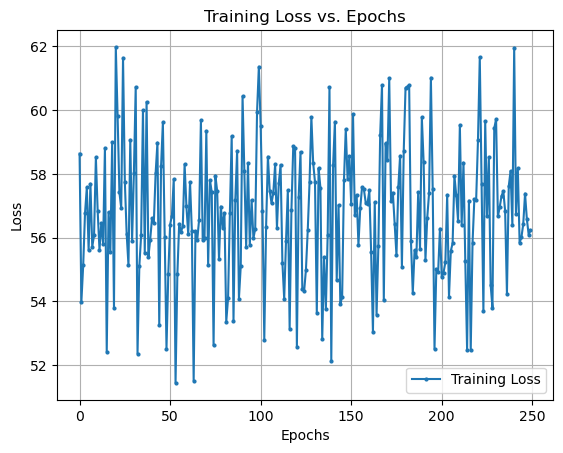

In [21]:
training_losses = [
    58.6336, 53.9873, 55.126, 56.7588, 57.5732, 55.6082, 57.6909, 55.7106, 56.0751, 58.5153, 56.8238, 55.611, 
    56.4575, 55.7997, 58.8152, 52.422, 56.8011, 55.5539, 58.9972, 53.7944, 61.9806, 59.8126, 57.4167, 56.9217, 
    61.6409, 57.7488, 56.1175, 55.1383, 59.0698, 55.891, 58.0357, 60.7276, 52.3598, 55.1091, 56.07, 59.9967, 
    55.5173, 60.2565, 55.3914, 55.9383, 56.6021, 56.4502, 58.0263, 58.9794, 53.2545, 58.2375, 59.6104, 56.0325, 
    52.5169, 54.8727, 56.4081, 56.6896, 57.8371, 51.4421, 54.8433, 56.4319, 56.1692, 56.3671, 58.3006, 56.979, 
    56.1108, 57.744, 56.2189, 51.5148, 56.1972, 55.939, 56.5576, 59.6796, 55.9363, 55.9895, 59.3481, 55.13, 
    57.8013, 57.4255, 52.6212, 57.945, 57.454, 55.3155, 56.9747, 56.3168, 56.7753, 53.3604, 54.0971, 56.7756, 
    59.1817, 53.3998, 57.174, 58.7238, 54.0889, 55.098, 60.4339, 58.0742, 55.6903, 58.3409, 55.7566, 57.1792, 
    55.9803, 56.2772, 59.9427, 61.3611, 59.5128, 56.8433, 52.8037, 56.339, 58.5389, 57.4711, 57.0807, 57.4134, 
    58.3017, 56.298, 57.7027, 58.2818, 55.2187, 54.075, 55.8968, 57.4841, 53.1462, 56.8796, 58.8643, 58.8166, 
    52.5758, 57.2852, 58.6869, 54.393, 54.3154, 54.9904, 56.2304, 57.7399, 59.7854, 58.3387, 57.7479, 53.6492, 
    58.1774, 57.5648, 52.81, 55.3789, 53.7461, 56.0686, 60.7111, 52.1335, 58.2642, 59.6349, 54.662, 57.0191, 
    53.9152, 54.1432, 57.7997, 59.4055, 57.847, 58.5494, 57.0398, 59.8668, 56.7065, 57.3414, 55.7744, 56.9356, 
    57.5875, 57.5211, 57.0986, 57.0684, 57.4804, 55.559, 53.0314, 57.1117, 53.5789, 55.7347, 59.2237, 60.7815, 
    54.0375, 58.9554, 58.433, 60.9971, 57.1436, 57.4098, 56.4278, 55.4388, 57.5786, 58.5677, 55.0815, 58.7024, 
    60.6961, 60.7317, 60.7907, 55.8781, 54.2569, 55.607, 55.4018, 57.43, 55.643, 59.7687, 58.3646, 55.3079, 
    56.6294, 57.394, 61.0163, 57.5296, 52.509, 55.0019, 54.907, 56.281, 54.7654, 54.9041, 55.2305, 57.3434, 
    54.1414, 55.5796, 55.8261, 57.9345, 57.3275, 56.5334, 59.5351, 56.4104, 58.3499, 55.2543, 52.4799, 57.1601, 
    52.4629, 55.8288, 57.2023, 57.184, 59.0457, 61.6647, 57.6761, 53.6971, 59.6554, 56.6643, 58.5303, 54.5136, 
    53.8021, 59.4289, 59.718, 56.6669, 56.9491, 57.3062, 57.455, 56.8362, 54.2401, 57.611, 58.0932, 56.3838, 
    61.9537, 56.7299, 58.1756, 55.8376, 56.0104, 56.4226, 57.3823, 56.5785, 56.0924, 56.2359]
    

epochs_plot = list(range(0,len(training_losses)))

# Plot training losses against epochs
plt.plot(epochs_plot, training_losses, marker='o', markersize=2, label='Training Loss')

# Add labels, title, and legend
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss vs. Epochs')
plt.grid(True)
plt.legend()

# Show the plot
plt.show()

#### Did increasing number of epochs help?
It seems the training loss is just oscillating around the same area. However, the validation loss has gone up a bit. Validation loss was lowest for the 100 epoch case, second lowest for the 250 epoch case, and highest for the 20 epoch case. The validation losses for the 100 and 250 epoch case were close. I do not want to try increasing the number of epochs more because I worry about overfitting. I will now try to test my CNN.

## Testing the CNN

In [12]:
# Define your criterion (loss function)
criterion = nn.MSELoss()  # or whatever loss function you're using

# Evaluate the model on the test dataset
test_loss, predictions, targets = evaluate_model(model, test_loader, criterion)

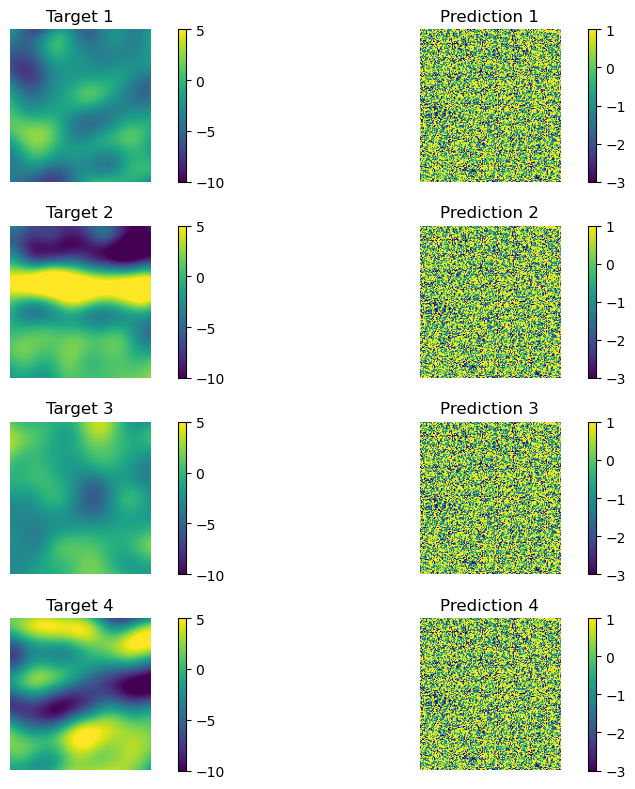

In [23]:
def plot_predictions_vs_targets(predictions, targets, num_samples=4):
    # Ensure we're only plotting a limited number of samples
    num_samples = min(num_samples, predictions.shape[0])

    # Create a figure with subplots
    fig, axes = plt.subplots(num_samples, 2, figsize=(10, 2 * num_samples))

    for i in range(num_samples):
        # Plot the target image
        ax = axes[i, 0]
        target_image = targets[i]
        
        # Check the number of dimensions and reshape if necessary
        if target_image.dim() == 3:
            img = ax.imshow(target_image.permute(1, 2, 0).cpu().numpy(), vmin=-10, vmax=5)  # (C, H, W) to (H, W, C)
        elif target_image.dim() == 2:
            img = ax.imshow(target_image.cpu().numpy(), vmin=-10, vmax=5)  # Single channel image
        ax.set_title(f'Target {i + 1}')
        ax.axis('off')

        # Add colorbar for the target image
        fig.colorbar(img, ax=ax)

        # Plot the predicted image
        ax = axes[i, 1]
        prediction_image = predictions[i]
        
        # Check the number of dimensions and reshape if necessary
        if prediction_image.dim() == 3:
            img = ax.imshow(prediction_image.permute(1, 2, 0).cpu().numpy(), vmin=-3, vmax=1)  # (C, H, W) to (H, W, C)
        elif prediction_image.dim() == 2:
            img = ax.imshow(prediction_image.cpu().numpy(), vmin=-3, vmax=1)  # Single channel image
        ax.set_title(f'Prediction {i + 1}')
        ax.axis('off')

        # Add colorbar for the predicted image
        fig.colorbar(img, ax=ax)

    plt.tight_layout()
    plt.show()


# Assuming predictions and targets are your outputs from the evaluation function
plot_predictions_vs_targets(predictions, targets, num_samples=4)  # Change num_samples as needed


### These all look the same
Are they even different? Let's compare between two prediction results.

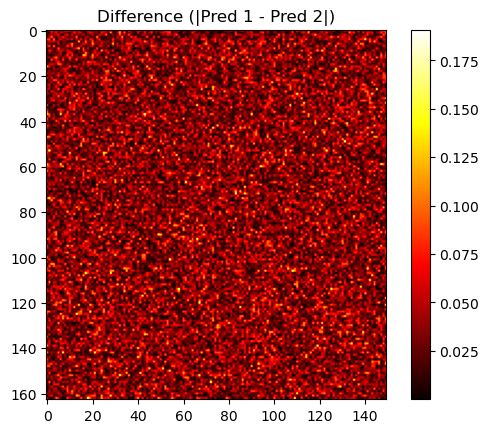

In [25]:
# Assuming predictions are stored as predictions (e.g., output of the evaluate_model function)
# and that they're of shape (num_samples, height, width)

# Select two predictions to compare, for example the first and the second
pred_1 = predictions[0].squeeze().cpu().numpy()  # Convert to numpy for plotting
pred_2 = predictions[1].squeeze().cpu().numpy()

difference = np.abs(pred_1 - pred_2)

# Plot the difference with a color bar
difference_plot = plt.imshow(difference, cmap='hot')  # Use a heatmap to emphasize differences
plt.title('Difference (|Pred 1 - Pred 2|)')
plt.colorbar(difference_plot) 

plt.show()


In [26]:
mse = np.mean((pred_1 - pred_2) ** 2)
print(f"Mean Squared Error between Prediction 1 and 2: {mse:.6f}")

Mean Squared Error between Prediction 1 and 2: 0.002306


## What is going on?
Seems that the validation losses decreased, but that wasn't a good enough indicator of whether the predictions would be good. My guess is that by allowing a high dropout rate of 0.7, the predictions became just noise. Perhaps they need to not have a dropout rate, and the rest of the hyperparameters can be tested. 

### Attempt with "optimal hyperparameters", but epochs = 100, dropout_rate = 0

In [11]:
lr = 0.01
dropout_rate = 0
optimizer = optim.Adam(model.parameters(), lr=lr)
epochs = 100

# Create datasets and DataLoader 
train_dataset = TensorDataset(training_NN_inputs)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=4)
test_dataset = TensorDataset(testing_NN_inputs)  
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

print(f"Training with lr={lr}, dropout_rate={dropout_rate}, optimizer=Adam, epochs={epochs}")
    
# Initialize model, loss function, and optimizer
dropout_rate = dropout_rate
model = SimpleCNN()
criterion = nn.MSELoss()  # Replace with your actual loss function
    
# Training loop for the specified number of epochs (already handled in train_model)
train_loss = train_model(model, train_loader, criterion, optimizer, num_epochs=epochs)  # Pass epochs here
val_loss, _, _ = evaluate_model(model, test_loader, criterion)  # Get val_loss from evaluate_model
    
# Print progress after training
print(f"Final Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

Training with lr=0.01, dropout_rate=0, optimizer=Adam, epochs=100
Epoch [1/100], Loss: 43.3056
Epoch [2/100], Loss: 43.3056
Epoch [3/100], Loss: 43.3056
Epoch [4/100], Loss: 43.3056
Epoch [5/100], Loss: 43.3056
Epoch [6/100], Loss: 43.3056
Epoch [7/100], Loss: 43.3056
Epoch [8/100], Loss: 43.3056
Epoch [9/100], Loss: 43.3056
Epoch [10/100], Loss: 43.3056
Epoch [11/100], Loss: 43.3056
Epoch [12/100], Loss: 43.3056
Epoch [13/100], Loss: 43.3056
Epoch [14/100], Loss: 43.3056
Epoch [15/100], Loss: 43.3056
Epoch [16/100], Loss: 43.3056
Epoch [17/100], Loss: 43.3056
Epoch [18/100], Loss: 43.3056
Epoch [19/100], Loss: 43.3056
Epoch [20/100], Loss: 43.3056
Epoch [21/100], Loss: 43.3056
Epoch [22/100], Loss: 43.3056
Epoch [23/100], Loss: 43.3056
Epoch [24/100], Loss: 43.3056
Epoch [25/100], Loss: 43.3056
Epoch [26/100], Loss: 43.3056
Epoch [27/100], Loss: 43.3056
Epoch [28/100], Loss: 43.3056
Epoch [29/100], Loss: 43.3056
Epoch [30/100], Loss: 43.3056
Epoch [31/100], Loss: 43.3056
Epoch [32/100

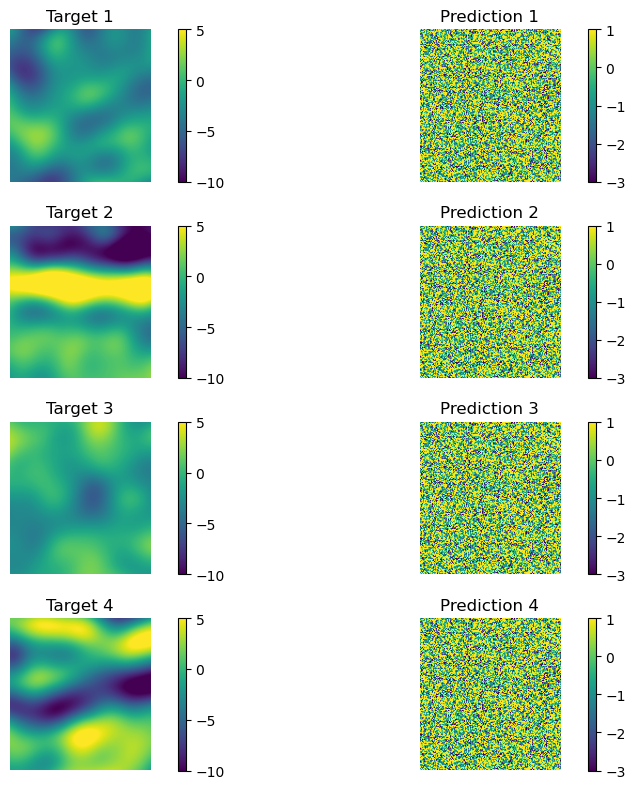

In [13]:
def plot_predictions_vs_targets(predictions, targets, num_samples=4):
    # Ensure we're only plotting a limited number of samples
    num_samples = min(num_samples, predictions.shape[0])

    # Create a figure with subplots
    fig, axes = plt.subplots(num_samples, 2, figsize=(10, 2 * num_samples))

    for i in range(num_samples):
        # Plot the target image
        ax = axes[i, 0]
        target_image = targets[i]
        
        # Check the number of dimensions and reshape if necessary
        if target_image.dim() == 3:
            img = ax.imshow(target_image.permute(1, 2, 0).cpu().numpy(), vmin=-10, vmax=5)  # (C, H, W) to (H, W, C)
        elif target_image.dim() == 2:
            img = ax.imshow(target_image.cpu().numpy(), vmin=-10, vmax=5)  # Single channel image
        ax.set_title(f'Target {i + 1}')
        ax.axis('off')

        # Add colorbar for the target image
        fig.colorbar(img, ax=ax)

        # Plot the predicted image
        ax = axes[i, 1]
        prediction_image = predictions[i]
        
        # Check the number of dimensions and reshape if necessary
        if prediction_image.dim() == 3:
            img = ax.imshow(prediction_image.permute(1, 2, 0).cpu().numpy(), vmin=-3, vmax=1)  # (C, H, W) to (H, W, C)
        elif prediction_image.dim() == 2:
            img = ax.imshow(prediction_image.cpu().numpy(), vmin=-3, vmax=1)  # Single channel image
        ax.set_title(f'Prediction {i + 1}')
        ax.axis('off')

        # Add colorbar for the predicted image
        fig.colorbar(img, ax=ax)

    plt.tight_layout()
    plt.show()


# Assuming predictions and targets are your outputs from the evaluation function
plot_predictions_vs_targets(predictions, targets, num_samples=4)  # Change num_samples as needed


## Final Analysis
Setting the dropout rate to zero gave us a constant training loss. The predictions are also ridiculously noisy now. Clearly, this hyperparameter search has taught us that dropout rate is not something to be included.